
# **Why Fairness Techniques Don't Always Ensure a Fair Model**
### **Considerations about using AI/ML fairness libraries (A case Study)**

As a data ethics practitioner, my role involves evaluation and analysis of fairness libraries and online code resources. Recently, I had the opportunity to explore a compelling [credit loan case study](https://fairlearn.org/main/auto_examples/plot_credit_loan_decisions.html) conducted by Ernst & Young and shared by Microsoft Fairlearn which aimed to apply and compare various post-processing and in-processing bias mitigation techniques.

To enhance understanding and provide valuable insights, I've created a more detailed and explanatory version of the codes available on the Fairlearn website. This effort also involved addressing certain errors. 

Let's delve into the important considerations regarding the use of fairness techniques in AI.

# Package Imports

In [ ]:
pip install fairlearn

In [ ]:
pip install xlrd

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

import lightgbm as lgb
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import (
    count,
    selection_rate,
    equalized_odds_difference,
    false_positive_rate,
    false_negative_rate,
)
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import EqualizedOdds
from sklearn.model_selection import train_test_split
import warnings

warnings.simplefilter("ignore")

rand_seed = 1234
np.random.seed(rand_seed)

for more information about the dataset or **download the dataset**, please refer to [**this**](https://www.kaggle.com/datasets/mohammadbolandraftar/credit-card-defaults-in-taiwan-ml-fairness) link

In [5]:
data_url = "/kaggle/input/credit-card-defaults-in-taiwan-ml-fairness/default of credit card clients (1).xls"
dataset = pd.read_excel(data_url, header=1).drop(columns=["ID"]).rename(columns={"PAY_0": "PAY_1", "default payment next month": "default"})

dataset.shape

(30000, 24)

In [6]:
dataset.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


we see there are three categorical features:

-   `SEX`: Sex of the applicant (as a binary feature)
-   `EDUCATION`: Highest level of education achieved by the
    applicant.
-   `MARRIAGE`: Marital status of the applicant.

**In this example, "SEX" is our sensitive feature**

In [7]:
categorical_features = ["SEX", "EDUCATION", "MARRIAGE"]

for col_name in categorical_features:
    dataset[col_name] = dataset[col_name].astype("category")

Y = dataset.loc[:, "default"]
A = dataset.loc[:, "SEX"] # our sensitive feature

X = pd.get_dummies(dataset.drop(columns=["default", "SEX"]))

A_str = A.map({1: "male", 2: "female"}) # mapping the numbers to string

# EDA

### Dataset imbalances

As part of an exploratory data analysis, let\'s explore the distribution of our sensitive feature `SEX`. We see that 60% of loan applicants were labeled as [female] and 40% as [male], so we do not need to worry about imbalance in this feature.


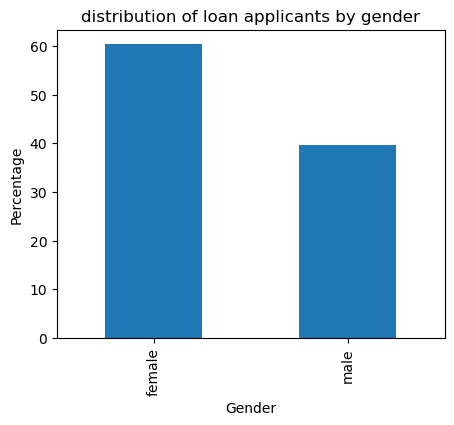

In [51]:
(A_str.value_counts(normalize=True)*100).round(2).plot(kind='bar', figsize=(5, 4))
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.title('distribution of loan applicants by gender')
plt.show()

Next, let's explore the distribution of the *loan default rate*`Y`. We see that around 78% of individuals in the dataset do not default on their credit loan.

**Note:**
* 1: default loan
* 0: non-default loan

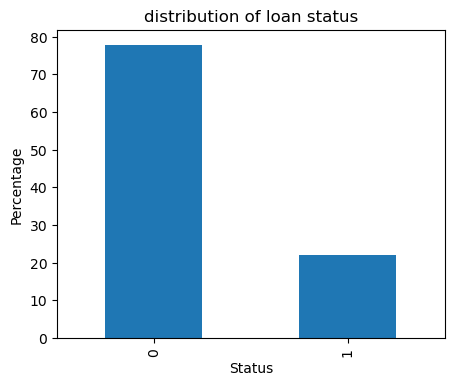

In [52]:
(Y.value_counts(normalize=True)*100).round(2).plot(kind='bar', figsize=(5, 4))
plt.xlabel('Status')
plt.ylabel('Percentage')
plt.title('distribution of loan status')
plt.show()

### Add synthetic noise that is related to the outcome and sex

**For the purpose of this case study**, the authors added a synthetic feature `Interest` that introduces correlation between the `SEX` label of an applicant and the `default` outcome. The purpose of this feature is to replicate outcome disparities present in the original dataset. 

In [ ]:
X.loc[:, "Interest"] = np.random.normal(loc=2 * Y, scale=A)

Now, we create a merged dataset for more EDAs purposes. we won't use it the future

In [11]:
merged_dataset = pd.concat([dataset, X["Interest"]], axis=1)

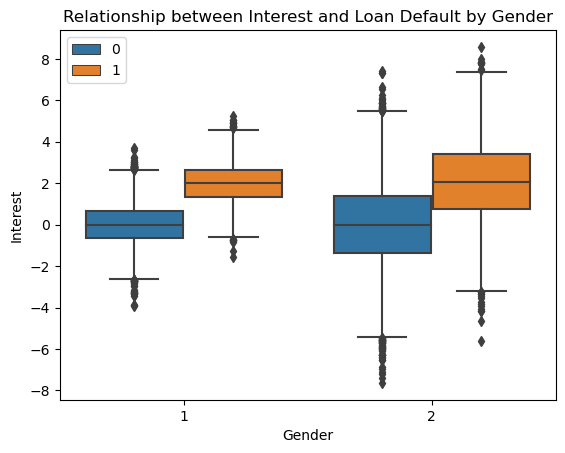

In [12]:
# Create a box plot
sns.boxplot(x='SEX', y='Interest', hue='default', data=merged_dataset)
plt.xlabel('Gender')
plt.ylabel('Interest')
plt.title('Relationship between Interest and Loan Default by Gender')
plt.legend()

plt.show()

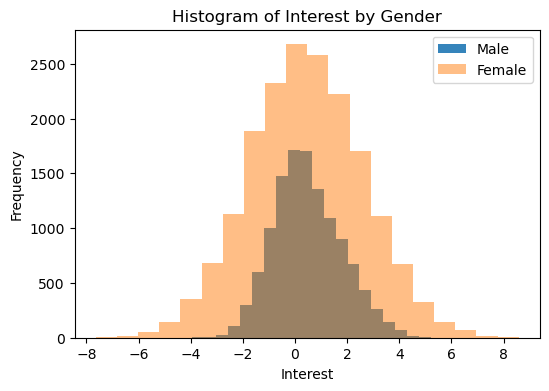

In [13]:
male_interest = merged_dataset[merged_dataset['SEX'] == 1]['Interest']
female_interest = merged_dataset[merged_dataset['SEX'] == 2]['Interest']

plt.figure(figsize=(6,4))
plt.hist(male_interest, bins=20, alpha=0.9, label='Male')
plt.hist(female_interest, bins=20, alpha=0.5, label='Female')

plt.xlabel('Interest')
plt.ylabel('Frequency')
plt.title('Histogram of Interest by Gender')
plt.legend()

plt.show()

### Check if this will lead to disparity in naive model
We see that for both sexes, the Interest feature is higher for individuals who defaulted on their loan.

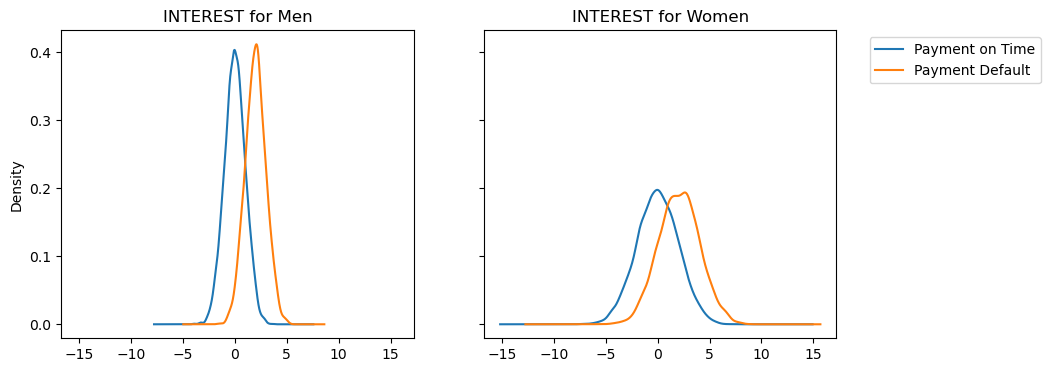

In [14]:
fig, (ax_1, ax_2) = plt.subplots(
    ncols=2, figsize=(10, 4), sharex=True, sharey=True
)
X["Interest"][(A == 1) & (Y == 0)].plot(
    kind="kde", label="Payment on Time", ax=ax_1, title="INTEREST for Men"
)
X["Interest"][(A == 1) & (Y == 1)].plot(
    kind="kde", label="Payment Default", ax=ax_1
)
X["Interest"][(A == 2) & (Y == 0)].plot(
    kind="kde",
    label="Payment on Time",
    ax=ax_2,
    legend=True,
    title="INTEREST for Women",
)
X["Interest"][(A == 2) & (Y == 1)].plot(
    kind="kde", label="Payment Default", ax=ax_2, legend=True
).legend(bbox_to_anchor=(1.6, 1))

plt.show()

# Training an initial model

In this section, we will train a fairness-unaware model on the training data. However because of the imbalances in the dataset, we will first resample the training data to produce a new balanced training dataset.

In [15]:
def resample_training_data(X_train, Y_train, A_train):
    """Down-sample the majority class in the training dataset to produce a
    balanced dataset with a 50/50 split in the predictive labels.

    Parameters:
    X_train: The training split of the features
    Y_train: The training split of the target labels
    A_train: The training split of the sensitive features

    Returns:
    Tuple of X_train, Y_train, A_train where each dataset has been re-balanced.
    """
    negative_ids = Y_train[Y_train == 0].index
    positive_ids = Y_train[Y_train == 1].index
    balanced_ids = positive_ids.union(
        np.random.choice(a=negative_ids, size=len(positive_ids))
    )

    X_train = X_train.loc[balanced_ids, :]
    Y_train = Y_train.loc[balanced_ids]
    A_train = A_train.loc[balanced_ids]
    return X_train, Y_train, A_train

X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, 
                                                                     Y, 
                                                                     A_str, 
                                                                     test_size=0.35, 
                                                                     stratify=Y,
                                                                    )

X_train, y_train, A_train = resample_training_data(X_train, y_train, A_train)

At this stage, we will train a *gradient-boosted tree classifier* using the `lightgbm` package on the balanced training dataset. When we evaluate the model, we will use the unbalanced testing dataset.


In [16]:
lgb_params = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.03,
    "num_leaves": 10,
    "max_depth": 3,
    "random_state": rand_seed,
    "n_jobs": 1,
}

estimator = Pipeline(
    steps=[
        ("preprocessing", StandardScaler()),
        ("classifier", lgb.LGBMClassifier(**lgb_params)), 
          ]
                    )

estimator.fit(X_train, y_train)

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier',
                 LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc',
                                n_jobs=1, num_leaves=10, objective='binary',
                                random_state=1234))])

We compute the *binary predictions* and the *prediction probabilities*
for the testing data points.


In [17]:
Y_pred_proba = estimator.predict_proba(X_test)[:, 1]
Y_pred = estimator.predict(X_test)

roc_auc_score(y_test, Y_pred_proba)

0.8782234705862874

From the *ROC Score*, we see the model appears to be differentiating between *true positives* and *false positives* well. This is to be expected given the `INTEREST` feature provides a strong
discriminant feature for the classification task.

# Feature Importance of the Unmitigated Classifier

As expected, our synthetic feature `INTEREST` has the highest feature importance because it is
highly correlated with the target variable, by construction.

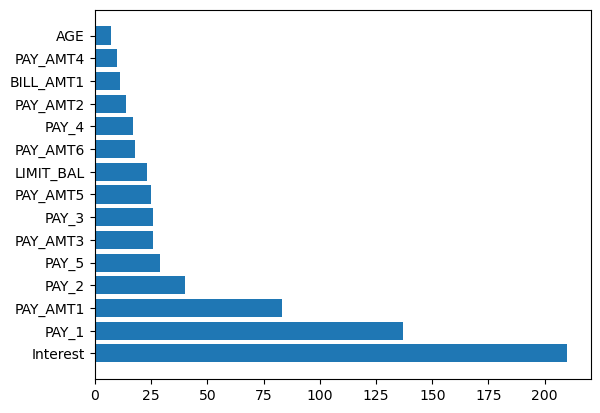

In [18]:
important_features = pd.DataFrame(X_train.columns, estimator[1].feature_importances_).reset_index()
important_features.columns = ["importance", "feature_name"]
important_features = important_features.sort_values(by="importance", ascending=False)

plt.barh(important_features["feature_name"][:15], important_features["importance"][:15])
plt.show()

# Fairness assessment of unmitigated model

### Define fairness metrics based on harms

In [19]:
def compute_error_metric(metric_value, sample_size):
    """Compute standard error of a given metric based on the assumption of
    normal distribution.

    Parameters:
    metric_value: Value of the metric
    sample_size: Number of data points associated with the metric

    Returns:
    The standard error of the metric
    """
    metric_value = metric_value / sample_size
    return (
        1.96
        * np.sqrt(metric_value * (1.0 - metric_value))
        / np.sqrt(sample_size)
    )


def false_positive_error(y_true, y_pred):
    """Compute the standard error for the false positive rate estimate."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return compute_error_metric(fp, tn + fp)


def false_negative_error(y_true, y_pred):
    """Compute the standard error for the false negative rate estimate."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return compute_error_metric(fn, fn + tp)


def balanced_accuracy_error(y_true, y_pred):
    """Compute the standard error for the balanced accuracy estimate."""
    fpr_error, fnr_error = false_positive_error(
        y_true, y_pred
    ), false_negative_error(y_true, y_pred)
    return np.sqrt(fnr_error**2 + fpr_error**2) / 2


fairness_metrics = {
    "count": count,
    "balanced_accuracy": balanced_accuracy_score,
    "balanced_acc_error": balanced_accuracy_error,
    "selection_rate": selection_rate,
    "false_positive_rate": false_positive_rate,
    "false_positive_error": false_positive_error,
    "false_negative_rate": false_negative_rate,
    "false_negative_error": false_negative_error,
}

Select a subset of metrics to report to avoid information overload


In [20]:
metrics_to_report = ["selection_rate", "false_positive_rate", "false_negative_rate", "balanced_accuracy",]

To compute the disaggregated performance metrics, we will use the `MetricFrame` object within the Fairlearn library. We will pass in our dictionary of metrics `fairness_metrics`, along with our test labels `y_test` and test predictions `Y_pred`. In addition, we pass in the *sensitive\_features* `A_test` to disaggregate our model results.

In [21]:
metricframe_unmitigated = MetricFrame(metrics=fairness_metrics, 
                                      y_true=y_test, 
                                      y_pred=Y_pred, 
                                      sensitive_features=A_test, 
                                     )

print("metricframe_unmitigated (fairness unaware):")
a = pd.DataFrame(metricframe_unmitigated.by_group[metrics_to_report])
b= pd.DataFrame(metricframe_unmitigated.overall[metrics_to_report], columns=["Overall"]).T
pd.concat([a,b])

metricframe_unmitigated (fairness unaware):


,selection_rate,false_positive_rate,false_negative_rate,balanced_accuracy
female,0.363981,0.255571,0.23573,0.754349
male,0.306475,0.132979,0.12423,0.871396
Overall,0.341143,0.207656,0.18898,0.801682


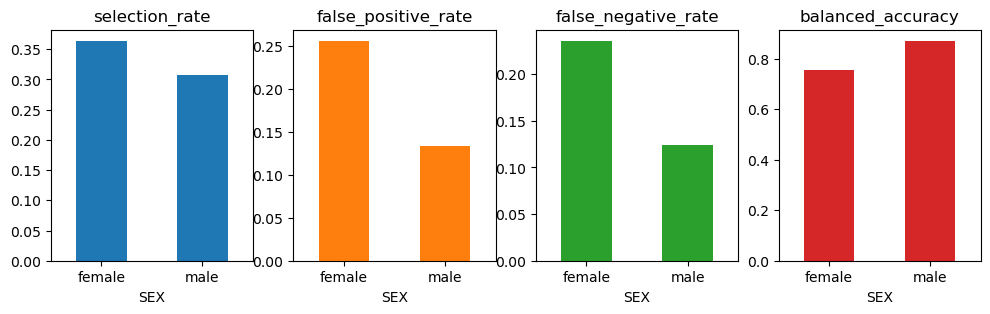

In [22]:
metricframe_unmitigated.by_group[metrics_to_report].iloc[:,0:4].plot.bar(subplots=True, 
                                                                         layout=[1, 4], 
                                                                         figsize=[12, 3], 
                                                                         legend=None, 
                                                                         rot=0
                                                                        )
plt.show()

In [54]:
balanced_accuracy_unmitigated = balanced_accuracy_score(y_test, Y_pred)
equalized_odds_unmitigated = equalized_odds_difference(
    y_test, Y_pred, sensitive_features=A_test
)

As we see, although "selection rate" is lower in male applicants, the other metrics are much better in this group. It's obvious that the model has **failed to fairly predict** the loan default in female applicants

**Definition of selection rate:** Selection rate refers to the proportion of loan applicants who are *predicted or classified as potential defaulters by a predictive model*. 

Selection Rate = (Number of Applicants Predicted as Defaulters / Total Number of Loan Applicants) * 100%

*Example:*
Let's consider a lending institution that receives 1,000 loan applications. A machine learning model is trained to predict whether an applicant is likely to default on their loan. After applying the model to the applications, the following outcomes are observed:

Number of Applicants Predicted as Defaulters: 150
Total Number of Loan Applicants: 1000
Using these numbers, we can calculate the selection rate:

Selection Rate = (150 / 1000) * 100% = 15%

# Mitigating Unfairness in ML models

In this section, we will discuss strategies for mitigating the performance disparities we found in our unmitigated model. We will apply two different mitigation strategies:

-   *Postprocessing*: In the postprocessing approach, the outputs of a trained classifer are transformed to satisfy some fairness criterion.
-   *In-processing (Reductions)*: In the reductions approach, we take in a model class and iteratively create a sequence of models that optimize some fairness constraint. Compared to the *postprocessing* approach, the fairness constraint is satisfied during the model training time rather than afterwards.

## Postprocessing Mitigations: Threshold Optimizer

To instantiate our `ThresholdOptimizer`, we need to specify our fairness constraint as a model parameter. Because both`false_negative_rate` disparities and `false_positive_rate` disparities translate into real-world harms in our scenario, we will aim to minimize the equalized_odds`{.sourceCode} difference as our *fairness constraint*.


The previous paragraph was copied from the case study but the <font color='red'>**main purpose of Equalized Odds is to true positive rate = false positive rate**</font>  across groups.

In [24]:
postprocess_est = ThresholdOptimizer(
    estimator=estimator,
    constraints="equalized_odds",  # Optimize FPR and FNR simultaneously (wrong)
    # other constraints available: "selection_rate_parity", ’{false,true}_{positive,negative}_rate_parity’
    objective="balanced_accuracy_score",
    prefit=True,
    predict_method="predict_proba",
)

postprocess_est

ThresholdOptimizer(constraints='equalized_odds',
                   estimator=Pipeline(steps=[('preprocessing',
                                              StandardScaler()),
                                             ('classifier',
                                              LGBMClassifier(learning_rate=0.03,
                                                             max_depth=3,
                                                             metric='auc',
                                                             n_jobs=1,
                                                             num_leaves=10,
                                                             objective='binary',
                                                             random_state=1234))]),
                   objective='balanced_accuracy_score',
                   predict_method='predict_proba', prefit=True)

One key limitation of the `ThresholdOptimizer` is the need for sensitive features during training and prediction time. If we do not have access to the `sensitive_features` during prediction time, we cannot use the `ThresholdOptimizer`.

We pass in `A_train` to the `fit` function with the `sensitive_features` parameter.


In [25]:
postprocess_est.fit(X=X_train, y=y_train, sensitive_features=A_train)

postprocess_pred = postprocess_est.predict(X_test, sensitive_features=A_test)

postprocess_pred_proba = postprocess_est._pmf_predict(X_test, sensitive_features=A_test)

Fairness assessment of postprocessing model
===========================================


In [56]:
bal_acc_postprocess = balanced_accuracy_score(y_test, postprocess_pred)

eq_odds_postprocess = equalized_odds_difference(y_test, postprocess_pred, sensitive_features=A_test)

metricframe_postprocess = MetricFrame(
    metrics=fairness_metrics,
    y_true=y_test,
    y_pred=postprocess_pred,
    sensitive_features=A_test,
)

In [57]:
print("metricframe Threshold Optimizer:")
c = pd.DataFrame(metricframe_postprocess.by_group[metrics_to_report])
d= pd.DataFrame(metricframe_postprocess.overall[metrics_to_report], columns=["Overall"]).T
pd.concat([c,d])

metricframe Threshold Optimizer:


,selection_rate,false_positive_rate,false_negative_rate,balanced_accuracy
female,0.379463,0.271431,0.221646,0.753461
male,0.395923,0.268461,0.185832,0.772854
Overall,0.386000,0.270270,0.206629,0.761550


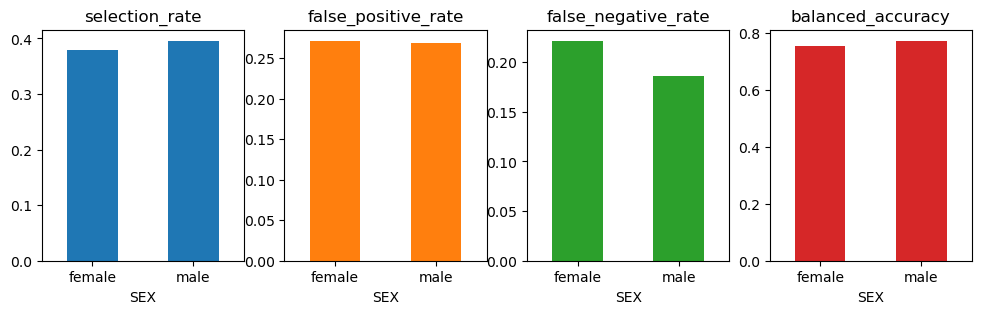

In [29]:
metricframe_postprocess.by_group[metrics_to_report].iloc[:,0:4].plot.bar(
    subplots=True, layout=[1, 4], figsize=[12, 3], legend=None, rot=0
)
plt.show()

# In-processing (Reductions) approach to unfairness mitigation

The main reduction algorithm in Fairlearn is `ExponentiatedGradient`. The algorithm creates a sequence
of re-weighted datasets and retrains the wrapped classifier on each of the datasets. This re-training process is guaranteed to find a model that satisfies the fairness constraints while optimizing the performance metric.

The model returned by `ExponentiatedGradient` consists of several inner models, returned by a wrapped estimator.

To instantiate an `ExponentiatedGradient` model, we pass in two parameters:

-   a base `estimator` (object that supports training)
-   fairness `constraints` (object of type fairlearn.reductions.Moment)

When passing in a fairness *constraint* as a `Moment`, we can specify an `epsilon` value representing the maximum allowed difference or ratio between our largest and smallest value. For example, in the below code, EqualizedOdds(difference_bound=epsilon)` means that we are using EqualizedOdds` as our fairness constraint, and we will allow a maximal difference of  epsilon`between our largest and smallest *equalized odds* value.


In [30]:
def get_expgrad_models_per_epsilon(
    estimator, epsilon, X_train, y_train, A_train
):
    """Instantiate and train an ExponentiatedGradient model on the
    balanced training dataset.

    Parameters
    ----------
    Estimator: Base estimator to contains a fit and predict function.
    Epsilon: Float representing maximum difference bound for the fairness Moment constraint

    Returns
    -------
    Predictors
        List of inner model predictors learned by the ExponentiatedGradient
        model during the training process.

    """
    exp_grad_est = ExponentiatedGradient(
        estimator=estimator,
        sample_weight_name='classifier__sample_weight',
        constraints=EqualizedOdds(difference_bound=epsilon),
    )
    # Is this an issue - Re-runs
    exp_grad_est.fit(X_train, y_train, sensitive_features=A_train)
    predictors = exp_grad_est.predictors_
    return predictors

Because the *performance-fairness trade-off* learned by the `ExponentiatedGradient` model is sensitive to our chosen
`epsilon` value, we can treat `epsilon` as a *hyperparameter* and iterate over a range of potential values. Here, we
will train two `ExponentiatedGradient` models, one with`epsilon=0.01` and the second with `epsilon=0.02`, and store the inner models learned through each of the training processes.

In practice, it's recommended choosing smaller values of epsilon` on the order of the *square root* of the number
of samples in the training dataset:
$\dfrac{1}{\sqrt{\text{numberSamples}}} \approx \dfrac{1}{\sqrt{25000}} \approx 0.01$


In [31]:
epsilons = [0.01, 0.02]

all_models = {}

for eps in epsilons:
    all_models[eps] = get_expgrad_models_per_epsilon(
        estimator=estimator,
        epsilon=eps,
        X_train=X_train,
        y_train=y_train,
        A_train=A_train,
    )

In [32]:
for epsilon, models in all_models.items():
    print(
        f"For epsilon {epsilon}, ExponentiatedGradient learned {len(models)} inner models"
    )

For epsilon 0.01, ExponentiatedGradient learned 17 inner models
For epsilon 0.02, ExponentiatedGradient learned 19 inner models


Here, we can see all the inner models learned for each value of `epsilon`. With the `ExponentiatedGradient`
model, we specify an `epsilon` parameter that represents the maximal disparity in our fairness metric that our final model should satisfy. For example, an `epsilon=0.02` means that the training value of the *equalized odds difference* of the returned model is at most `0.02` (if the algorithm converges).

## Reviewing inner models of ExponentiatedGradient

In [33]:
def is_pareto_efficient(points):
    """Filter a NumPy Matrix to remove rows that are strictly dominated by
    another row in the matrix. Strictly dominated means the all the row values
    are greater than the values of another row.

    Parameters
    ----------
    Points: NumPy array (NxM) of model metrics.
        Assumption that smaller values for metrics are preferred.

    Returns
    -------
    Boolean Array
        Nx1 boolean mask representing the non-dominated indices.
    """
    n, m = points.shape
    is_efficient = np.ones(n, dtype=bool)
    for i, c in enumerate(points):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(
                points[is_efficient] < c, axis=1
            )
            is_efficient[i] = True
    return is_efficient

In [34]:
def filter_dominated_rows(points):
    """Remove rows from a DataFrame that are monotonically dominated by
    another row in the DataFrame.

    Parameters
    ----------
    Points: DataFrame where each row represents the summarized performance
            (balanced accuracy, fairness metric) of an inner model.

    Returns
    -------
    pareto mask: Boolean mask representing indices of input DataFrame that are not monotonically dominated.
    masked_DataFrame: DataFrame with dominated rows filtered out.

    """
    pareto_mask = is_pareto_efficient(points.to_numpy())
    return pareto_mask, points.loc[pareto_mask, :]

In [35]:
def aggregate_predictor_performances(
    predictors, metric, X_test, Y_test, A_test=None
):
    """Compute the specified metric for all classifiers in predictors.
    If no sensitive features are present, the metric is computed without
    disaggregation.

    Parameters
    ----------
    predictors: A set of classifiers to generate predictions from.
    metric: The metric (callable) to compute for each classifier in predictor
    X_test: The data features of the testing data set
    Y_test: The target labels of the teting data set
    A_test: The sensitive feature of the testing data set.

    Returns
    -------
    List of performance scores for each classifier in predictors, for the
    given metric.
    """
    all_predictions = [predictor.predict(X_test) for predictor in predictors]
    if A_test is not None:
        return [
            metric(Y_test, Y_sweep, sensitive_features=A_test)
            for Y_sweep in all_predictions
        ]
    else:
        return [metric(Y_test, Y_sweep) for Y_sweep in all_predictions]

In [36]:
def model_performance_sweep(models_dict, X_test, y_test, A_test):
    """Compute the equalized_odds_difference and balanced_error_rate for a
    given list of inner models learned by the ExponentiatedGradient algorithm.
    Return a DataFrame containing the epsilon level of the model, the index
    of the model, the equalized_odds_difference score and the balanced_error
    for the model.

    Parameters
    ----------
    models_dict: Dictionary mapping model ids to a model.
    X_test: The data features of the testing data set
    y_test: The target labels of the testing data set
    A_test: The sensitive feature of the testing data set.

    Returns
    -------
    DataFrame where each row represents a model (epsilon, index) and its
    performance metrics
    """
    performances = []
    for (eps, models) in models_dict.items():
        eq_odds_difference = aggregate_predictor_performances(
            models, equalized_odds_difference, X_test, y_test, A_test
        )
        bal_acc_score = aggregate_predictor_performances(
            models, balanced_accuracy_score, X_test, y_test
        )
        for (i, score) in enumerate(eq_odds_difference):
            performances.append((eps, i, score, (1 - bal_acc_score[i])))
    performances_df = pd.DataFrame.from_records(
        performances,
        columns=["epsilon", "index", "equalized_odds", "balanced_error"],
    )
    return performances_df

In [37]:
performance_df = model_performance_sweep(all_models, X_test, y_test, A_test)
performance_df

,epsilon,index,equalized_odds,balanced_error
0,0.01,0,0.122592,0.198318
1,0.01,1,0.120384,0.197860
2,0.01,2,0.366542,0.637947
3,0.01,3,0.117107,0.199406
4,0.01,4,0.367404,0.640109
5,0.01,5,0.222162,0.466605
6,0.01,6,0.106041,0.198932
7,0.01,7,0.185680,0.320563
8,0.01,8,0.098136,0.198655
9,0.01,9,0.028247,0.254847


In [38]:
performance_subset = performance_df.loc[:, ["equalized_odds", "balanced_error"]]

In [39]:
mask, pareto_subset = filter_dominated_rows(performance_subset)

performance_df_masked = performance_df.loc[mask, :]

**Now, let's plot the performance trade-offs between all of our models.**


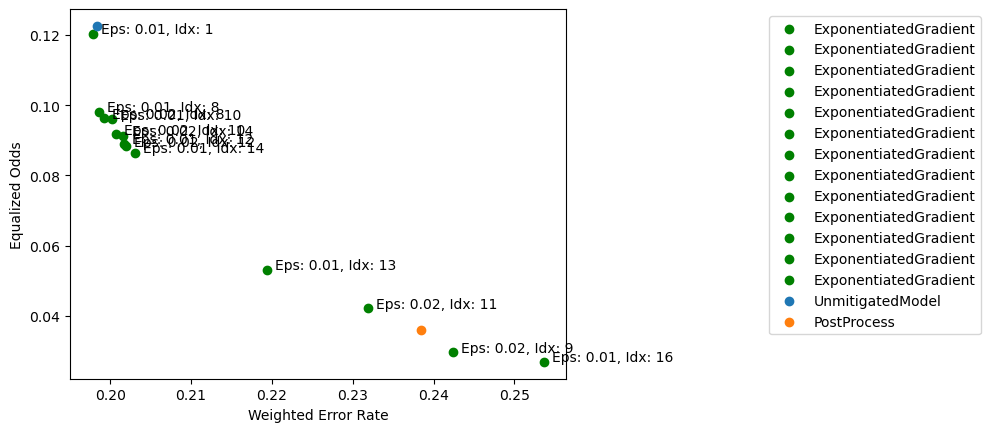

In [40]:
for index, row in performance_df_masked.iterrows():
    bal_error, eq_odds_diff = row["balanced_error"], row["equalized_odds"]
    epsilon_, index_ = row["epsilon"], row["index"]
    plt.scatter(
        bal_error, eq_odds_diff, color="green", label="ExponentiatedGradient"
    )
    plt.text(
        bal_error + 0.001,
        eq_odds_diff + 0.0001,
        f"Eps: {epsilon_}, Idx: {int(index_)}",
        fontsize=10,
    )
plt.scatter(
    1.0 - balanced_accuracy_unmitigated,
    equalized_odds_unmitigated,
    label="UnmitigatedModel",
)
plt.scatter(
    1.0 - bal_acc_postprocess, eq_odds_postprocess, label="PostProcess"
)
plt.xlabel("Weighted Error Rate")
plt.ylabel("Equalized Odds")
plt.legend(bbox_to_anchor=(1.85, 1))
plt.show()

With the above plot, we can see how the performance of the non-dominated
inner models compares to the original unmitigated model. In many cases,
we see that a reduction in the `equalized_odds_difference` is accompanied by a small increase in the *weighted error rate*.

## Selecting a suitable inner model



One strategy we can use to select a model is creating a *threshold*
based on the *balanced error rate* of the unmitigated model. Then out of
the filtered models, we select the model that minimizes the
`equalized_odds_difference`{.sourceCode}. The process can be broken down
into the three steps below:

1.  Create threshold based on `balanced_error`{.sourceCode} of the
    unmitigated model.
2.  Filter only models whose `balanced_error`{.sourceCode} are below the
    threshold.
3.  Choose the model with smallest `equalized_odds`{.sourceCode}
    difference.

Within the context of fair lending in the United States, if a financial
institution is found to be engaging in discriminatory behavior, they
must produce documentation that demonstrates the model chosen is the
least discriminatory model while satisfying profitability and other
business needs. In our approach, the business need of profitability is
simulated by thresholding based on the `balanced_error`{.sourceCode}
rate of the unmitigated model, and we choose the least discriminatory
model based on the smallest `equalized_odds_difference`{.sourceCode}
value.


In [41]:
def filter_models_by_unmitigiated_score(
    all_models,
    models_frames,
    unmitigated_score,
    performance_metric="balanced_error",
    fairness_metric="equalized_odds",
    threshold=0.01,
):
    """Filter out models whose performance score is above the desired
    threshold. Out of the remaining model, return the models with the best
    score on the fairness metric.

    Parameters
    ----------
    all_models: Dictionary (Epsilon, Index) mapping (epilson, index number) pairs to a Model object
    models_frames: A DataFrame representing each model's performance and fairness score.
    unmitigated_score: The performance score of the unmitigated model.
    performance_metric: The model performance metric to threshold on.
    fairness_metric: The fairness metric to optimize for
    threshold: The threshold padding added to the :code:`unmitigated_score`.

    """
    # Create threshold based on balanced_error of unmitigated model and filter
    models_filtered = models_frames.query(
        f"{performance_metric} <= {unmitigated_score + threshold}"
    )
    best_row = models_filtered.sort_values(by=[fairness_metric]).iloc[0]
    # Choose the model with smallest equalized_odds difference
    epsilon, index = best_row[["epsilon", "index"]]
    return {
        "model": all_models[epsilon][index],
        "epsilon": epsilon,
        "index": index,
    }

In [42]:
best_model = filter_models_by_unmitigiated_score(
    all_models,
    models_frames=performance_df,
    unmitigated_score=(1.0 - balanced_accuracy_unmitigated),
    threshold=0.015,
)

print(
    f"Epsilon for best model: {best_model.get('epsilon')}, Index number: {best_model.get('index')}"
)
inprocess_model = best_model.get("model")

Epsilon for best model: 0.01, Index number: 14.0


Now we have selected our best inner model, let\'s collect the model\'s
predictions on the test dataset and compute the relevant performance
metrics.


In [43]:
y_pred_inprocess = inprocess_model.predict(X_test)

bal_acc_inprocess = balanced_accuracy_score(y_test, y_pred_inprocess)
eq_odds_inprocess = equalized_odds_difference(
    y_test, y_pred_inprocess, sensitive_features=A_test
)

In [44]:
metricframe_inprocess = MetricFrame(
    metrics=fairness_metrics,
    y_true=y_test,
    y_pred=y_pred_inprocess,
    sensitive_features=A_test,
)

In [45]:
print("metricframe ExponentiatedGradient:")
e = pd.DataFrame(metricframe_inprocess.by_group[metrics_to_report])
f = pd.DataFrame(metricframe_inprocess.overall[metrics_to_report], columns=["Overall"]).T
pd.concat([c,d])

metricframe ExponentiatedGradient:


,selection_rate,false_positive_rate,false_negative_rate,balanced_accuracy
female,0.379463,0.271431,0.221646,0.753461
male,0.395923,0.268461,0.185832,0.772854
Overall,0.386000,0.270270,0.206629,0.761550


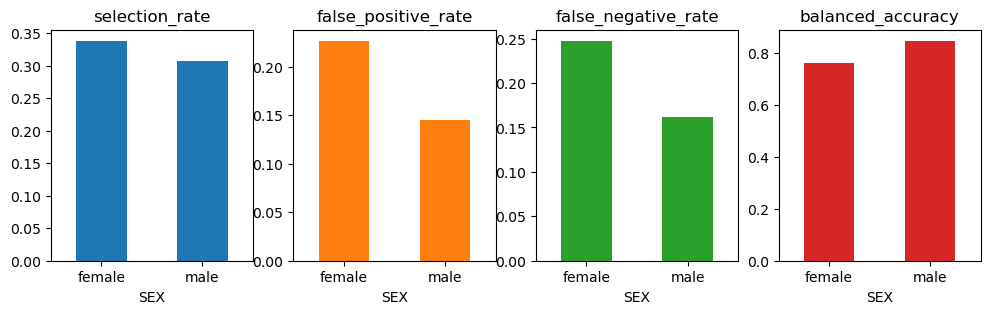

In [46]:
metricframe_inprocess.by_group[metrics_to_report].iloc[:,0:4].plot.bar(
    subplots=True, layout=[1, 4], figsize=[12, 3], legend=None, rot=0
)
plt.show()

## **A Simple Test**
let's see what happens if I pick Epsilon=0.02 , IDx = 11

In [47]:
my_model = all_models[0.02][11]
y_pred_inprocess_02 = my_model.predict(X_test)

bal_acc_inprocess_02 = balanced_accuracy_score(y_test, y_pred_inprocess_02)
eq_odds_inprocess_02 = equalized_odds_difference(
    y_test, y_pred_inprocess_02, sensitive_features=A_test
)

metricframe_inprocess_02 = MetricFrame(
    metrics=fairness_metrics,
    y_true=y_test,
    y_pred=y_pred_inprocess_02,
    sensitive_features=A_test,
)

In [48]:
metricframe_inprocess_02.by_group[metrics_to_report]

,selection_rate,false_positive_rate,false_negative_rate,balanced_accuracy
SEX,,,,
female,0.323065,0.213411,0.272053,0.757268
male,0.335252,0.202753,0.229979,0.783634


# Discussion: Comparing the Results

Now we have trained two different fairness-aware models using the *postprocessing* approach and the *reductions* approach. Let's compare the performance of these models to our original fairness-unaware model.


In [49]:
unmitigated_df = pd.DataFrame(metricframe_unmitigated.by_group[metrics_to_report].unstack())
unmitigated_df.columns = ["unmitigated_df"]
unmitigated_df = unmitigated_df.T

postprocess_df = pd.DataFrame(metricframe_postprocess.by_group[metrics_to_report].unstack())
postprocess_df.columns = ["postprocess_df"]
postprocess_df = postprocess_df.T

inprocess_df = pd.DataFrame(metricframe_inprocess.by_group[metrics_to_report].unstack())
inprocess_df.columns = ["inprocess_df"]
inprocess_df = inprocess_df.T

compare_results = pd.concat([unmitigated_df, postprocess_df, inprocess_df], axis=0)
round(compare_results *100, 2)

selection_rate        false_positive_rate         \
SEX                    female   male              female   male   
unmitigated_df          36.40  30.65               25.56  13.30   
postprocess_df          37.95  39.59               27.14  26.85   
inprocess_df            33.87  30.72               22.67  14.52   

               false_negative_rate        balanced_accuracy         
SEX                         female   male            female   male  
unmitigated_df               23.57  12.42             75.43  87.14  
postprocess_df               22.16  18.58             75.35  77.29  
inprocess_df                 24.76  16.12             76.29  84.68

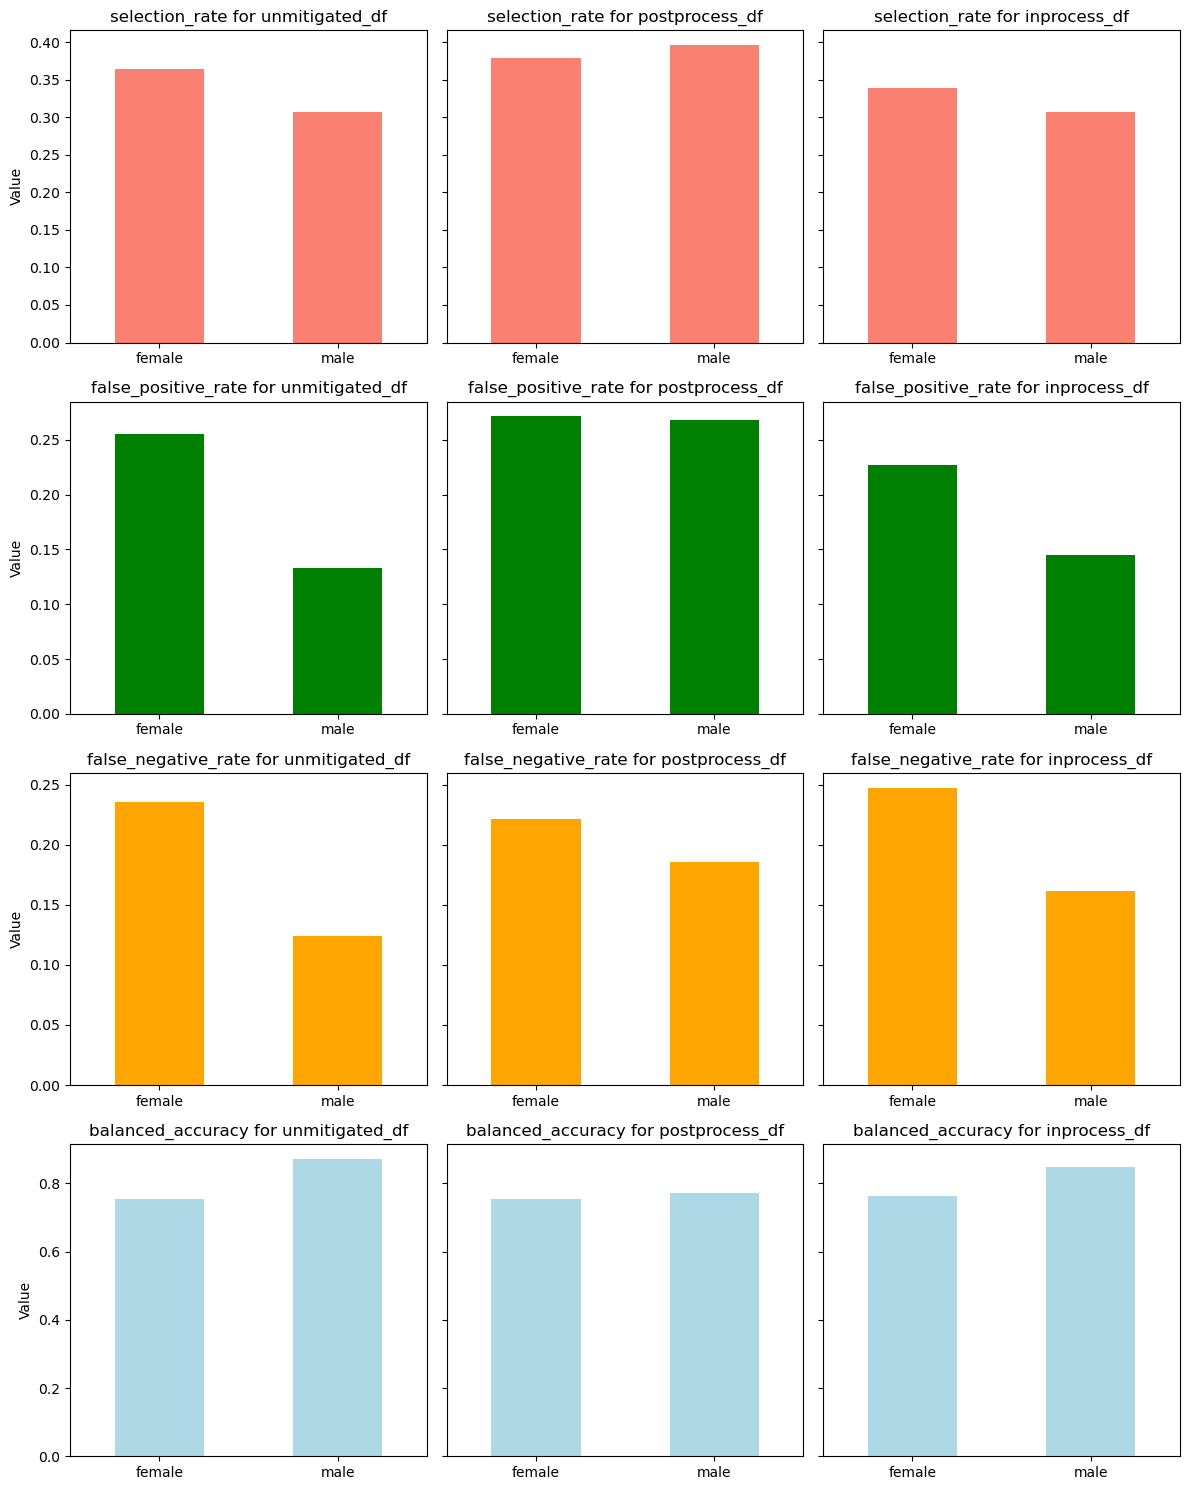

In [58]:
column_colors = ['salmon', 'green', 'orange', 'lightblue']

fig, axs = plt.subplots(4, 3, figsize=(12, 15), sharey='row')

for i, col in enumerate(['selection_rate', 'false_positive_rate', 'false_negative_rate', 'balanced_accuracy']):

    color = column_colors[i]
    
    for j, row in enumerate(['unmitigated_df', 'postprocess_df', 'inprocess_df']):
        subset = compare_results.xs(col, axis=1, level=0).loc[row]
        subset.plot(kind='bar', ax=axs[i, j], rot=0, color=[color, color])

        axs[i, j].set_title(f'{col} for {row}')
        axs[i, j].set_xlabel('')
        axs[i, j].set_ylabel('Value')

plt.tight_layout()

plt.show()

## A quick reminder:
**False Positive Rate (FPR):**

•	Definition: FPR represents the proportion of cases that the model incorrectly predicts as positive (loan defaults) but are actually negative (they can repay the loan). 

•	Who is Harmed: High FPR in a loan default model can harm individuals who are incorrectly flagged as potential defaulters.

**False Negative Rate (FNR):**

•	Definition: FNR represents the proportion of cases that the model incorrectly predicts as negative (loan repayments) but are actually positive (they fail to repay the loan). 

•	Who is Harmed: High FNR in a loan default model can harm the lender by failing to identify individuals who will default on their loans.


## Discussion

**Selection Rate:**

In the unmitigated dataframe, a significant disparity exists between male and female applicants. The application of mitigation techniques notably reduces this gap.

**False Positive Rate (FPR):**

Both mitigation techniques demonstrate improvements in fairness compared to the fairness-unaware model, with a notable reduction in the gender gap. However, it's worth highlighting that the post-processing model, in particular, exhibits considerably worse results than the unmitigated technique. The in-process technique, while more promising, does show a slight increase in FPR.

**False Negative Rate (FNR):**

Despite narrowing the gap between male and female applicants, most models, except for female applicants in the post-processing technique, exhibit suboptimal performance in terms of FNR.


# Conclusion

The case study serves as an illuminating example that underscores the nuanced nature of fairness in AI/ML models. To achieve a fairer model, we must consider the following key points:

* **Balancing Fairness and Costs:** The objective of fairness is to narrow the gap among different demographic groups, such as male and female applicants in this case. However, it's crucial to weigh the costs associated with employing each mitigation technique. Additionally, we should assess whether overall fairness has improved or not as we strive for a balanced approach.

* **Diversify Mitigation Techniques:** Relying solely on a single mitigation technique may not suffice. As demonstrated here, post-processing technique excel in reducing FPR, while in-process mitigation model perform better in terms of FNR. Combining different techniques can lead to more comprehensive fairness improvements.

* **Utilize Multiple Fairness Metrics:** As per Google Responsible AI practices, it's essential to evaluate models using a range of fairness metrics. This multifaceted approach provides a more thorough understanding of model behavior and fairness.

* **Explore Holistic Approaches:** While bias mitigation techniques are valuable, remember that fairness can also be enhanced by adjusting hyperparameters or employing pre-processing techniques. A holistic perspective allows for various avenues to achieve fairness.

* **Broad Assessment:** Extend your evaluation to encompass standard discrimination metrics, such as the Adverse Impact Ratio or Standardized Mean Difference, across a diverse array of ML models. For more detailed information, refer to [Responsible Machine Learning Book](https://www.oreilly.com/library/view/responsible-machine-learning/9781492090878/).

In sum, the journey toward fairness in AI and ML models is multifaceted and requires careful consideration of various factors. By adopting a comprehensive approach that embraces diverse techniques, metrics, and assessments, we can strive to build more equitable and just models.
